In [5]:
import os
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

In [6]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

In [7]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

In [8]:
def show_landmarks(ax, image, landmarks):
    ax.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

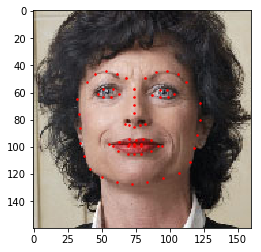

In [9]:
image = io.imread(os.path.join('data/faces/', img_name))
show_landmarks(plt.subplot(), image, landmarks)

In [71]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [11]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [52]:
# transform
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

In [55]:
# transform
class RandomCrop():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        img = image[top : top + new_h, left : left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': img, 'landmarks': landmarks}

In [58]:
# transform
class ToTensor():
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        img = torch.from_numpy(image.transpose((2, 0, 1)))
        landmarks = torch.from_numpy(landmarks)
        
        return {'image': img, 'landmarks': landmarks}

In [62]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', 
                                    root_dir='data/faces/')

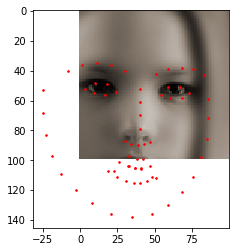

In [63]:
crop = RandomCrop(100)
sample = crop(face_dataset[0])
show_landmarks(plt.subplot(), **sample)

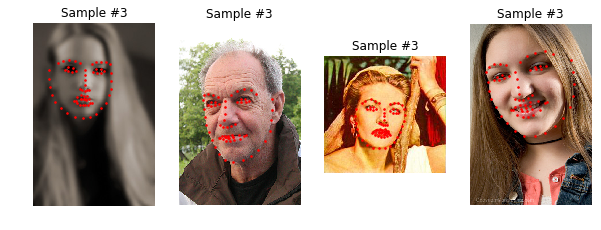

In [64]:
plt.figure(figsize=(10, 5))
axes = []
for i in range(4):
    sample = face_dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    axes.append((ax, sample))
    
for ax, sample in axes:
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(ax, **sample)

In [99]:
tsfm = transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()])
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', 
                                           root_dir='data/faces/', transform=tsfm)

C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


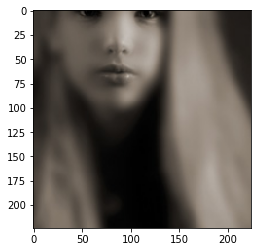

In [112]:
plt.imshow(transformed_dataset[0]['image'].numpy().transpose((1, 2, 0)))

In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

In [128]:
sample_batched = iter(dataloader).next()

C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [129]:
image_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
batch_size = len(image_batch)
img_size = image_batch.size(2)

(-55.41732223575136, 905.5, 227.5, -27.01243296699809)

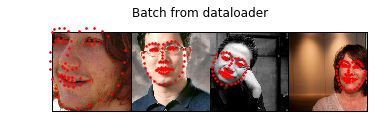

In [134]:
grid = utils.make_grid(image_batch)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
for i in range(batch_size):
    plt.scatter(landmarks_batch[i, :, 0].numpy() + i * img_size, 
                landmarks_batch[i, :, 1].numpy(), s=10, marker='.', c='r')

plt.title('Batch from dataloader')
plt.axis('off')